In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF

from skimage import io, transform
from pathlib import Path

In [56]:

plt.rcParams["savefig.bbox"] = 'tight'
# orig_img = Image.open(Path('assets') / 'astronaut.jpg')
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        # row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [70]:
image_dir = Path("data/CelebAMask-HQ/CelebA-HQ-img/")
mask_dir = Path("data/CelebAMask-HQ/hair_masks/")
text_dir = Path("data/CelebAMask-HQ/labels/")


class TextMaskDataset(Dataset):
    """Images with masks and descriptions"""

    def __init__(self, image_dir, mask_dir, text_dir, texts_per_img=10, img_size=128):
        """
        Args:
            image_dir: Path of directory containing image files. All images are .jpg files and are named only with an index
            mask_dir: Path of directory containing mask files. All masks are .png files and are named only with an index
            text_dir: Path of directory containing text files. All texts are .txt files and are named only with an index. Each line of a text file contains a description of the corresponding image
            texts_per_img: How many descriptions there are for each image, defaults to 10
            img_size: height and width which the images shall be scaled to, defaults to 128
        """
        self.path_image_dir = Path(image_dir)
        self.path_mask_dir = Path(mask_dir)
        self.path_text_dir = Path(text_dir)
        self.texts_per_img = texts_per_img
        self.img_size = img_size

        self.descriptions = []
        self._init_descriptions()
    
    def _init_descriptions(self):
        self.descriptions = []
        total_file_count = self.__len__()
        print("Initialising descriptions... ", end="")
        for i in range(total_file_count):
            text_file = self.path_text_dir / f"{i}.txt"
            img_descriptions = text_file.read_text().split("\n")
            img_descriptions = [x.strip() for x in img_descriptions if x.strip()][:self.texts_per_img]
            self.descriptions.append(img_descriptions)
            print(f"{i}/{total_file_count}", end="\r")
        print("Finished initialising texts!")

    def __len__(self):
        return len([x for x in self.path_image_dir.iterdir()])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        path_img = self.path_image_dir / f"{idx}.jpg"
        path_mask = self.path_mask_dir / f"{idx}.png"

        image = io.imread(path_img)
        mask = io.imread(path_mask)

        # transforms

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        # Resize 
        resize = transforms.Resize(size=(self.img_size + 10, self.img_size + 10))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(self.img_size, self.img_size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if np.random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Rotate
        rotation = transforms.RandomRotation.get_params(degrees=[-30,30])
        image = TF.rotate(image, rotation)
        mask = TF.rotate(mask, rotation)

        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)


        text = self.descriptions[idx][np.random.randint(self.texts_per_img)]


        return image, mask, text

In [71]:
dataset = TextMaskDataset(image_dir=image_dir, mask_dir=mask_dir, text_dir=text_dir)

Finished initialising texts!30000


In [63]:
img, mask, text = dataset[0]

In [64]:
mask.shape

torch.Size([3, 128, 128])

In [72]:
mask_inverted = 1 - mask

In [75]:
masked_image = img * mask_inverted

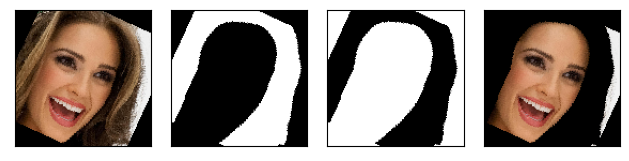

In [76]:
plot([img.permute(1,2,0), mask.permute(1,2,0),mask_inverted.permute(1,2,0), masked_image.permute(1,2,0)])